In [1]:
# This notebook will contain only some NLP methods such as n-grams because the full notebook was getting too cumbersum.
# Data has been transformed in other notebook, we can just load it in here :)

In [2]:
# imports
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# index_col stops index being read as column
df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)

In [4]:
df_turk

,button,event_type,target,time,x,y,step,turkId
0,1,mousedown,alloc-slider-1,0.000,477.0,405.0,1,A35YFAFWP33C70
1,1,mouseup,alloc-slider-1,0.111,478.0,405.0,1,A35YFAFWP33C70
2,1,click,alloc-slider-1,0.111,478.0,405.0,1,A35YFAFWP33C70
3,1,mousedown,alloc-slider-1,1.516,479.0,405.0,1,A35YFAFWP33C70
4,1,mousedirchange,alloc-slider-1,2.395,543.0,403.0,1,A35YFAFWP33C70
...,...,...,...,...,...,...,...,...
1293068,1,click,html,258.656,500.0,2198.0,1,A15781PHGW377Y
1293069,1,click,html,258.656,500.0,2198.0,2,A15781PHGW377Y
1293070,1,click,html,258.656,500.0,2198.0,3,A15781PHGW377Y
1293071,1,click,html,258.656,500.0,2198.0,4,A15781PHGW377Y


In [5]:

def calculate_ngrams(dataframe, n):
    # TODO docstring
    # will return a dataframe of ngrams and frequency given n
    # Can take a while to compute
    
    IDs = dataframe['turkId'].unique()
    all_ngrams = []

    for ID in IDs:
        # Get targets of each user
        targets = dataframe[ dataframe['turkId'] == ID ] ['target'].to_numpy()

        ngrams_generator = nltk.ngrams(targets, n)               # creates ngram generator, can be used to find ngrams
        ngrams_distribution = nltk.FreqDist(ngrams_generator)    # nltk distribution. in form ngrams:frequency
        common_ngrams = ngrams_distribution.most_common()       # converts to list

        # append this useres ngrams to all ngrams
        # extend rather than append to iterate over list and not add a list of items as a single item.
        all_ngrams.extend(common_ngrams)

    # Convert list to dataframe
    df_ngrams = pd.DataFrame(all_ngrams, columns =['n-grams', 'Frequency'])
    df_ngrams = df_ngrams.astype(dtype= {"n-grams":"object", "Frequency":"int64"})

    # Change n-grams series from list of tuples to list of strings  # https://stackoverflow.com/questions/59993097/how-can-i-join-tuples-to-strings-in-a-pandas-dataframe
    df_ngrams['n-grams'] = df_ngrams['n-grams'].agg(' : '.join)

    # Sum the frequencies of similar ngrams.
    df_ngrams = df_ngrams.groupby(['n-grams']).sum().reset_index().sort_values(by='Frequency', ascending=False)

    # 'Normalise' the frequencies to compare lab and turk.
    # frequency of ngram divided by number of users
    df_ngrams['Relative Frequency'] = df_ngrams['Frequency'].divide(len(IDs))
    return df_ngrams.reset_index(drop=True)

# NOTE: This wont take into account outliers. 
# Say if noone touched slider 2 other than 1 user, we would still say slider 2 was very frequent event if it was only 1 user.



In [6]:
lab_unigrams = calculate_ngrams(df_lab, 1)
print(lab_unigrams.head())
turk_unigrams = calculate_ngrams(df_turk, 1)
print(turk_unigrams.head())


n-grams  Frequency  Relative Frequency
0  alloc-slider-4       7116          508.285714
1  alloc-slider-2       6952          496.571429
2  alloc-slider-3       6324          451.714286
3            html       6114          436.714286
4  alloc-slider-5       5892          420.857143
          n-grams  Frequency  Relative Frequency
0            html     230332          596.715026
1  alloc-slider-2     137228          355.512953
2  alloc-slider-5     127649          330.696891
3  alloc-slider-4     122440          317.202073
4  alloc-slider-1     105512          273.347150


In [7]:
lab_unigrams['n-grams'][1]

'alloc-slider-2'

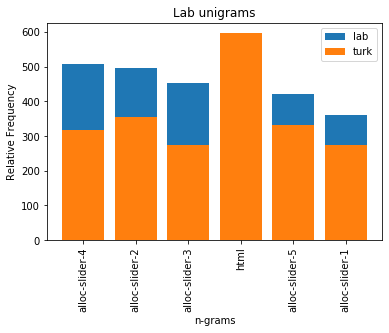

In [8]:
plt.bar(lab_unigrams['n-grams'].head(10), lab_unigrams['Relative Frequency'].head(10), label='lab')
plt.bar(turk_unigrams['n-grams'].head(10), turk_unigrams['Relative Frequency'].head(10), label='turk')

labels = df_lab['target'].value_counts()[:20]    # Get first 20 most frequent items
labels = labels.index.to_list()   # items to list


#plt.xticks((labels))
#plt.xticks(('html_other', 'alloc-slider-2', 'alloc-slider-3'))
plt.xlabel("n-grams")
plt.xticks(rotation=90)
plt.ylabel("Relative Frequency")
plt.title("Lab unigrams")
plt.legend(loc='best')

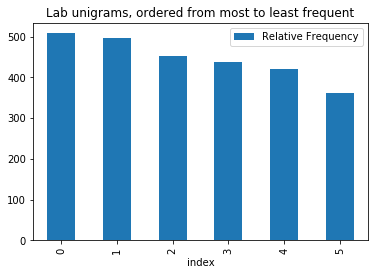

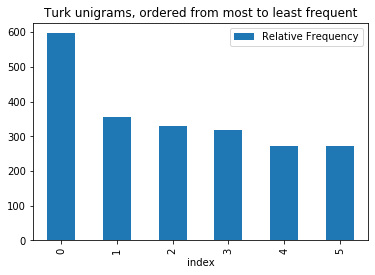

In [9]:
# These plots show the frequency of different unique n-grams in Lab and Turk data.
# I can see that anything after the 10th most frequent item contains almost no occurances so it can be removed.

lab_unigrams.reset_index().plot.bar(x='index', y='Relative Frequency', title='Lab unigrams, ordered from most to least frequent')
turk_unigrams.reset_index().plot.bar(x='index', y='Relative Frequency', title='Turk unigrams, ordered from most to least frequent')

,n-grams,Frequency,Relative Frequency
0,alloc-slider-4,7116,508.285714
1,alloc-slider-2,6952,496.571429
2,alloc-slider-3,6324,451.714286
3,html,6114,436.714286
4,alloc-slider-5,5892,420.857143
5,alloc-slider-1,5066,361.857143


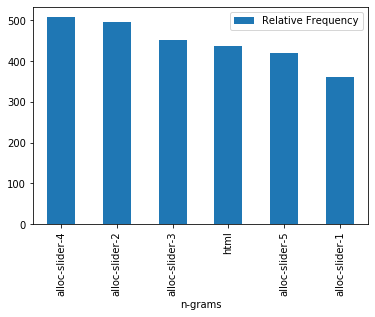

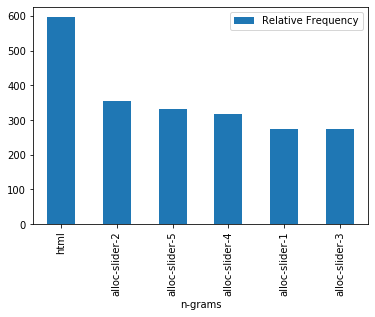

In [10]:
lab_unigrams.head(10).plot.bar(x='n-grams', y='Relative Frequency')
turk_unigrams.head(10).plot.bar(x='n-grams', y='Relative Frequency')

# Create these plots but with a breakdown in each column showing what ID it came from.
# This will help us identidy any outliers, and remove them if they are skewing the resutls.
# TODO create a stacked bar chart in tableau by adding column to n-grams dataframe of ID.

lab_unigrams

Now we've done some exploration into unigrams, lets look at tri-grams to see if theres anything interesting going on.


In [11]:
lab_trigrams = calculate_ngrams(df_lab, 3)
turk_trigrams = calculate_ngrams(df_turk, 3)

print(lab_trigrams.head())
print(turk_trigrams.head())

n-grams  Frequency  \
0  alloc-slider-4 : alloc-slider-4 : alloc-slider-4       6600   
1  alloc-slider-2 : alloc-slider-2 : alloc-slider-2       6413   
2  alloc-slider-3 : alloc-slider-3 : alloc-slider-3       5781   
3                                html : html : html       5482   
4  alloc-slider-5 : alloc-slider-5 : alloc-slider-5       5430   

   Relative Frequency  
0          471.428571  
1          458.071429  
2          412.928571  
3          391.571429  
4          387.857143  
                                            n-grams  Frequency  \
0                                html : html : html     209398   
1  alloc-slider-2 : alloc-slider-2 : alloc-slider-2     125230   
2  alloc-slider-5 : alloc-slider-5 : alloc-slider-5     117848   
3  alloc-slider-4 : alloc-slider-4 : alloc-slider-4     111007   
4  alloc-slider-1 : alloc-slider-1 : alloc-slider-1      97036   

   Relative Frequency  
0          542.481865  
1          324.430052  
2          305.305699  
3         

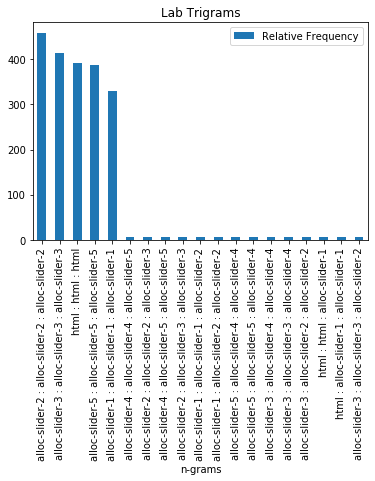

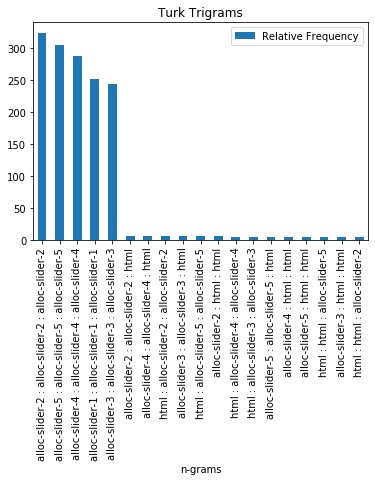

In [12]:
#[1:20] hides the first result which is much more frequent and hides everything else
lab_trigrams[1:20].plot.bar(x='n-grams', y='Relative Frequency', title='Lab Trigrams')
turk_trigrams[1:20].plot.bar(x='n-grams', y='Relative Frequency', title='Turk Trigrams')

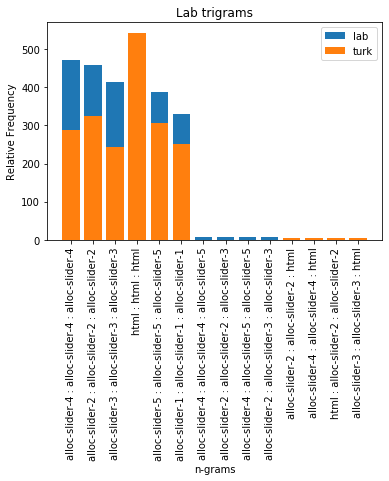

In [13]:
plt.bar(lab_trigrams['n-grams'].head(10), lab_trigrams['Relative Frequency'].head(10), label='lab')
plt.bar(turk_trigrams['n-grams'].head(10), turk_trigrams['Relative Frequency'].head(10), label='turk')

#plt.xticks((labels))
#plt.xticks(('html_other', 'alloc-slider-2', 'alloc-slider-3'))
plt.xlabel("n-grams")
plt.xticks(rotation=90)
plt.ylabel("Relative Frequency")
plt.title("Lab trigrams")
plt.legend(loc='best')

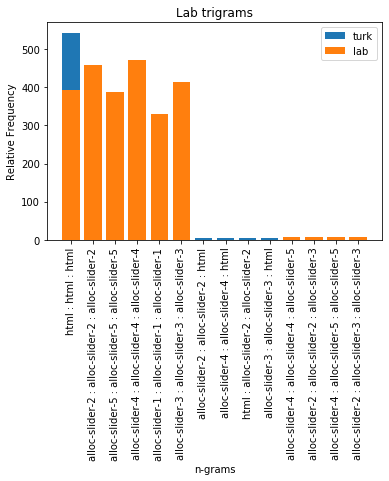

In [14]:
plt.bar(turk_trigrams['n-grams'].head(10), turk_trigrams['Relative Frequency'].head(10), label='turk')
plt.bar(lab_trigrams['n-grams'].head(10), lab_trigrams['Relative Frequency'].head(10), label='lab')


#plt.xticks((labels))
#plt.xticks(('html_other', 'alloc-slider-2', 'alloc-slider-3'))
plt.xlabel("n-grams")
plt.xticks(rotation=90)
plt.ylabel("Relative Frequency")
plt.title("Lab trigrams")
plt.legend(loc='best')

In [15]:
turk_trigrams

,n-grams,Frequency,Relative Frequency
0,html : html : html,209398,542.481865
1,alloc-slider-2 : alloc-slider-2 : alloc-slider-2,125230,324.430052
2,alloc-slider-5 : alloc-slider-5 : alloc-slider-5,117848,305.305699
3,alloc-slider-4 : alloc-slider-4 : alloc-slider-4,111007,287.582902
4,alloc-slider-1 : alloc-slider-1 : alloc-slider-1,97036,251.388601
...,...,...,...
179,alloc-slider-3 : alloc-slider-2 : alloc-slider-4,1,0.002591
180,alloc-slider-5 : alloc-slider-1 : alloc-slider-2,1,0.002591
181,alloc-slider-4 : alloc-slider-2 : alloc-slider-4,1,0.002591
182,html : alloc-slider-2 : alloc-slider-4,1,0.002591


Maybe bi-grams will be better to use

n-grams  Frequency  Relative Frequency
0  alloc-slider-4 : alloc-slider-4       6853          489.500000
1  alloc-slider-2 : alloc-slider-2       6671          476.500000
2  alloc-slider-3 : alloc-slider-3       6046          431.857143
3                      html : html       5768          412.000000
4  alloc-slider-5 : alloc-slider-5       5655          403.928571
                           n-grams  Frequency  Relative Frequency
0                      html : html     218849          566.966321
1  alloc-slider-2 : alloc-slider-2     131076          339.575130
2  alloc-slider-5 : alloc-slider-5     122611          317.645078
3  alloc-slider-4 : alloc-slider-4     116549          301.940415
4  alloc-slider-1 : alloc-slider-1     101207          262.194301


,n-grams,Frequency,Relative Frequency
0,html : html,218849,566.966321
1,alloc-slider-2 : alloc-slider-2,131076,339.575130
2,alloc-slider-5 : alloc-slider-5,122611,317.645078
3,alloc-slider-4 : alloc-slider-4,116549,301.940415
4,alloc-slider-1 : alloc-slider-1,101207,262.194301
5,alloc-slider-3 : alloc-slider-3,99723,258.349741
6,alloc-slider-2 : html,2533,6.562176
7,alloc-slider-4 : html,2489,6.448187
8,alloc-slider-3 : html,2424,6.279793
9,html : alloc-slider-2,2413,6.251295


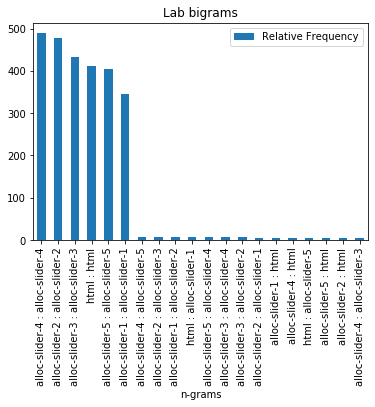

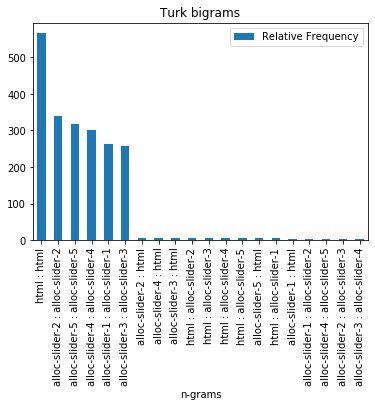

In [16]:
lab_bigrams = calculate_ngrams(df_lab, 2)
turk_bigrams = calculate_ngrams(df_turk, 2)

print(lab_bigrams.head())
print(turk_bigrams.head())

lab_bigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency', title='Lab bigrams')
turk_bigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency', title='Turk bigrams')

turk_bigrams

(<matplotlib.axes._subplots.AxesSubplot at 0x28aa93cc548>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28aa93b9348>)

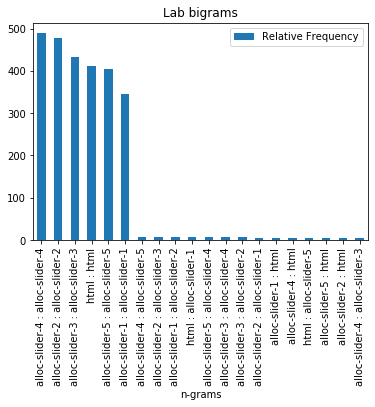

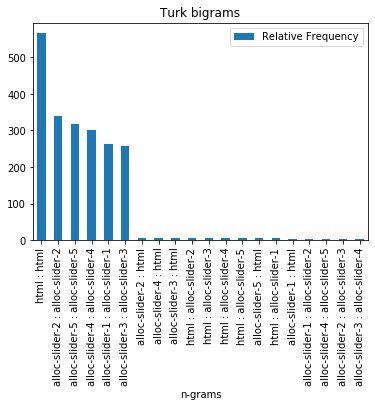

In [17]:
lab_bigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency', title='Lab bigrams'),turk_bigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency', title='Turk bigrams')

# New idea

Now we know what the average turk and lab data distribution looks like for unigrams, bigrams, and trigrams.
Next I need to make a function that will return the count of each different gram for EACH INDIVIDUAL.
Then I can compare the counts of these people the counts of the average.

TODO: Do a scatterplot where the x-axis is the the different ngrams and the y axis is count of ngrams for each individual. Each users datapoint will be a different colour x.

After this maybe try with different ngrams being different axis or something.

In [18]:
def calculate_users_ngrams(dataframe, n):
    # TODO docstring
    # will return a dataframe of ngrams and frequency given n
    # Can take a while to compute
    
    IDs = dataframe['turkId'].unique()
    all_users_ngram_counts = []
    all_users_ID = []

    for ID in IDs:
        # Get targets of each user
        targets = dataframe[ dataframe['turkId'] == ID ] ['target'].to_numpy()

        ngrams_generator = nltk.ngrams(targets, n)               # creates ngram generator, can be used to find ngrams
        ngrams_distribution = nltk.FreqDist(ngrams_generator)    # nltk distribution. in form ngrams:frequency
        common_ngrams = ngrams_distribution.most_common()       # converts to list

        all_users_ngram_counts.extend(common_ngrams)

        # TODO Change so we append everything as a list and then turn everything into a dataframe outside the loop to massively improve effecienncy

        # Add users ID as a new column
        ID_column = [ID] * len(common_ngrams)
        all_users_ID.extend(ID_column)

    #print(len(all_users_ngram_counts[0][5]))

    # Convert list to dataframe
    df_ngrams = pd.DataFrame(all_users_ngram_counts, columns =['n-grams', 'Frequency'])
    df_ngrams = df_ngrams.astype(dtype= {"n-grams":"object", "Frequency":"int64"})
    df_ngrams['n-grams'] = df_ngrams['n-grams'].agg(' : '.join)

    # 'Normalise' the frequencies to compare lab and turk.
    # frequency of ngram divided by number of users

    # Add ID column
    df_ngrams['turkId'] = all_users_ID

    return df_ngrams

lab_users_unigrams = calculate_users_ngrams(df_lab, 1)
turk_users_unigrams = calculate_users_ngrams(df_turk, 1)

In [19]:
lab_users_unigrams

,n-grams,Frequency,turkId
0,alloc-slider-3,682,ID1
1,alloc-slider-1,650,ID1
2,alloc-slider-2,570,ID1
3,alloc-slider-5,521,ID1
4,alloc-slider-4,235,ID1
...,...,...,...
79,alloc-slider-3,428,ID18
80,alloc-slider-5,349,ID18
81,alloc-slider-4,311,ID18
82,alloc-slider-1,308,ID18


In [20]:
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0, 'alloc-slider-3')

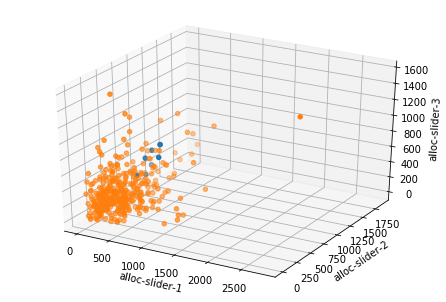

In [21]:
ax = Axes3D(plt.figure())

ax.scatter(lab_users_unigrams [lab_users_unigrams['n-grams'] == 'alloc-slider-1'] ['Frequency'] ,
    lab_users_unigrams [lab_users_unigrams['n-grams'] == 'alloc-slider-2'] ['Frequency'] , 
    lab_users_unigrams [lab_users_unigrams['n-grams'] == 'alloc-slider-3'] ['Frequency'])


ax.scatter(turk_users_unigrams [turk_users_unigrams['n-grams'] == 'alloc-slider-1'] ['Frequency'].head(380) ,
    turk_users_unigrams [turk_users_unigrams['n-grams'] == 'alloc-slider-2'] ['Frequency'].head(380) , 
    turk_users_unigrams [turk_users_unigrams['n-grams'] == 'alloc-slider-3'] ['Frequency'].head(380))

ax.set_xlabel('alloc-slider-1')
ax.set_ylabel('alloc-slider-2')
ax.set_zlabel('alloc-slider-3')

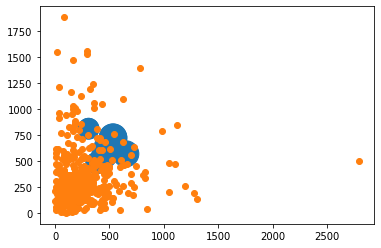

In [22]:
plt.scatter( 
    lab_users_unigrams [lab_users_unigrams['n-grams'] == 'alloc-slider-1'] ['Frequency'] ,
    lab_users_unigrams [lab_users_unigrams['n-grams'] == 'alloc-slider-2'] ['Frequency'] , 
    lab_users_unigrams [lab_users_unigrams['n-grams'] == 'alloc-slider-3'] ['Frequency'] )

plt.scatter( 
    turk_users_unigrams [turk_users_unigrams['n-grams'] == 'alloc-slider-1'] ['Frequency'].head(380) , 
    turk_users_unigrams [turk_users_unigrams['n-grams'] == 'alloc-slider-2'] ['Frequency'].head(380) )


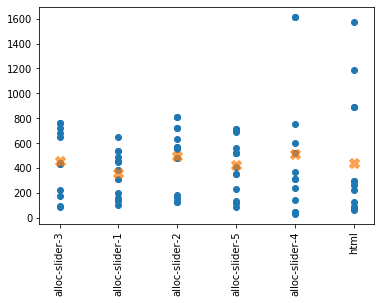

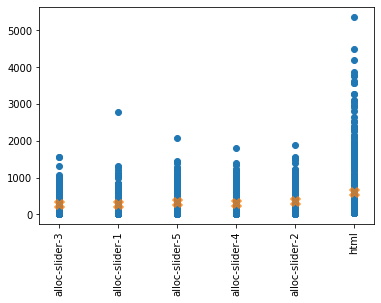

In [23]:
plt.scatter(lab_users_unigrams['n-grams'], lab_users_unigrams['Frequency'] )
plt.scatter(lab_unigrams['n-grams'], lab_unigrams['Relative Frequency'], marker='X', s=100, alpha=0.7 )
plt.xticks(rotation=90)
plt.show()

plt.scatter(turk_users_unigrams['n-grams'], turk_users_unigrams['Frequency'] )
plt.scatter(turk_unigrams['n-grams'], turk_unigrams['Relative Frequency'], marker='X', s=100, alpha=0.7 )
plt.xticks(rotation=90)
plt.show()

In [24]:
lab_users_bigrams = calculate_users_ngrams(df_lab, 2)
turk_users_bigrams = calculate_users_ngrams(df_turk, 2)

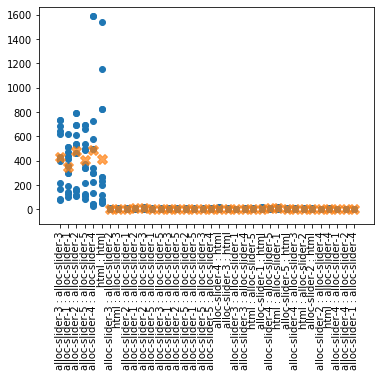

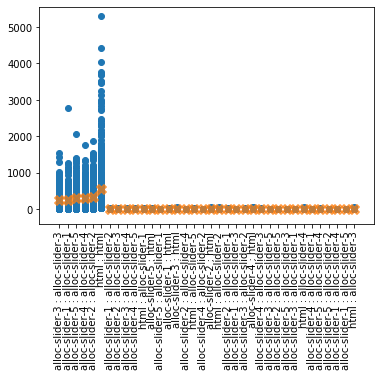

In [25]:

plt.scatter(lab_users_bigrams['n-grams'], lab_users_bigrams['Frequency'] )
plt.scatter(lab_bigrams['n-grams'], lab_bigrams['Relative Frequency'], marker='X', s=100, alpha=0.7 )
plt.xticks(rotation=90)
plt.show()

plt.scatter(turk_users_bigrams['n-grams'], turk_users_bigrams['Frequency'] )
plt.scatter(turk_bigrams['n-grams'], turk_bigrams['Relative Frequency'], marker='X', s=100, alpha=0.7 )
plt.xticks(rotation=90)
plt.show()

In [26]:
# TODO: Plot the 'average' values for the distribution of these points on the same chart.


# Here they suggest bayes filtering can be used to detect language, maybe I use too?
https://stackoverflow.com/questions/101569/algorithm-to-detect-similar-documents-in-python-script

# Naive Bayes
Another idea from SPAM detection is using a naive bayes, here they get the count of each word for each email and bayes it.
Could even use this to get the counts of 2/3-grams to compare?
https://towardsdatascience.com/spam-filtering-using-naive-bayes-98a341224038

TODO: I think for any of these to be used we would have to properly rename all the mouse items so they match

In [27]:
# Another idea from SPAM detection is using a naive bayes, here they get the count of each word for each email and bayes it.
# Could even use this to get the counts of 2/3-grams to compare?
# https://towardsdatascience.com/spam-filtering-using-naive-bayes-98a341224038

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score



In [28]:
# Converts a pandas datafram of targets to a list of strings
def targets_to_string(dataframe):
    IDs = dataframe['turkId'].unique()
    targets_text = []

    for ID in IDs:
        targets_series = dataframe[ dataframe['turkId'] == ID ] ['target']
        targets =  ', '.join(targets_series)
        targets_text.append( targets)
        #targets_text = targets

    return targets_text

turk_targets = targets_to_string(df_turk)
lab_targets = targets_to_string(df_lab)
turk_labels = np.zeros( len(turk_targets) )
lab_labels = np.ones( len(lab_targets) )


In [29]:
# Append targets and labels
X = np.append(turk_targets, lab_targets)

y = np.append(turk_labels, lab_labels)

In [30]:
len(lab_targets)

14

In [31]:
# Test train split


X_train, X_test, y_train, y_test = train_test_split(X, y)

In [32]:
#Explore CountVecotrizer

vectorizer = CountVectorizer() 
counts = vectorizer.fit_transform(X_train)
p = counts.toarray()

In [33]:
p   # This is wrong, there should be 6 columns, 5 for each slider and 1 html other

array([[1167,  276, 1167],
       [1078,   50, 1078],
       [1536, 1382, 1536],
       [1185,  902, 1185],
       [ 401,  709,  401],
       [2542,   76, 2542],
       [ 368,  396,  368],
       [1529,   74, 1529],
       [ 437,  838,  437],
       [2069, 2409, 2069],
       [1464,   89, 1464],
       [1363,   74, 1363],
       [ 803,  133,  803],
       [1723, 1407, 1723],
       [ 433,   70,  433],
       [ 812,  125,  812],
       [2038,  892, 2038],
       [ 254,  141,  254],
       [1741,  839, 1741],
       [ 992,   60,  992],
       [6666,  314, 6666],
       [2945,  161, 2945],
       [ 656,   42,  656],
       [ 596,   73,  596],
       [ 994,   35,  994],
       [1758, 1125, 1758],
       [1135,  693, 1135],
       [2046,   51, 2046],
       [ 688,  129,  688],
       [1041,   98, 1041],
       [1914, 1902, 1914],
       [1108,  119, 1108],
       [ 475,  940,  475],
       [1438,  131, 1438],
       [3016, 2524, 3016],
       [1548,   41, 1548],
       [ 307,   56,  307],
 

In [34]:
# Instantiating Multinomial Naive Bayes Classifier
classifier = MultinomialNB()
targets = y_train
classifier.fit(counts, targets)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [35]:
example_count = vectorizer.transform(X_test)
predictions = classifier.predict(example_count)
predictions

array([0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.])

In [36]:
from sklearn.metrics import accuracy_score

print( accuracy_score(y_test, predictions) )

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)



0.42


array([[37, 58],
       [ 0,  5]], dtype=int64)

Accuracy score: 0.42
F1 score: 0.35383244206773623
[[37 58]
 [ 0  5]]


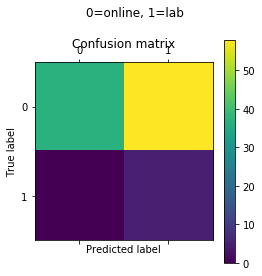

In [37]:

print( f'Accuracy score: {accuracy_score(y_test, predictions)}' )
f1 = f1_score(y_test, predictions, average='macro')
print( f'F1 score: {f1}' )

# High accuracy because of imbalenced classes 
# https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/
# This website has some nice references about imblaenced class distributions. TODO: use in diss.
# data sampling – customized algorithms– cost sensitive algorithms– one class algorithms – threshold moving – probability calibration


# https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
# Better ways of dealing with imbalenced data

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [38]:
# Above has too much online data so there are uneven classes.
# Look at only the first X (20 or so) online data for training

#X_train, X_test, y_train, y_test = train_test_split(X, y)

# TODO: make classes balenced

lab_length = len(lab_targets)

X_balanced = np.append( turk_targets[ :lab_length ] , lab_targets)

y_balanced = np.append(turk_labels[ :lab_length ], lab_labels)

print(f'Length of lab and turk data: {len(X_balanced)}')

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced)

vectorizer = CountVectorizer() 
counts = vectorizer.fit_transform(X_train)

classifier = MultinomialNB()
targets = y_train
classifier.fit(counts, targets)

example_count = vectorizer.transform(X_test)
predictions = classifier.predict(example_count)

print( f'Accuracy score: {accuracy_score(y_test, predictions)}' )
f1 = f1_score(y_test, predictions, average='macro')
print( f'F1 score: {f1}' )
cm = confusion_matrix(y_test, predictions)
print(cm)


Length of lab and turk data: 28
Accuracy score: 0.5714285714285714
F1 score: 0.5333333333333332
[[1 2]
 [1 3]]


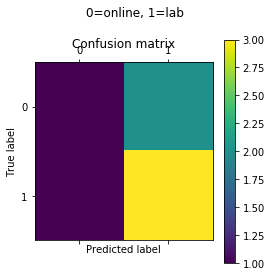

In [39]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Accuracy score: 0.8571428571428571
F1 score: 0.8571428571428571
[[3 0]
 [1 3]]


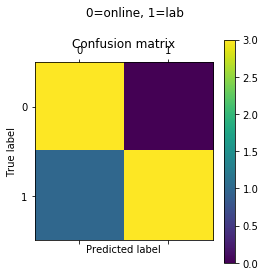

In [40]:
# Try a different method of Spam classification
# https://towardsdatascience.com/spam-detection-with-logistic-regression-23e3709e522


from sklearn.linear_model import LogisticRegression

######################
# Even class sizes

Spam_model = LogisticRegression(solver='liblinear', penalty='l1')
Spam_model.fit(counts, y_train)

example_count = vectorizer.transform(X_test)
pred = Spam_model.predict(example_count)
print( f'Accuracy score: {accuracy_score(y_test,pred)}' )
f1 = f1_score(y_test, pred, average='macro')
print( f'F1 score: {f1}' )
# Accuracy of 0.66% not the best but also not bad.
# TODO: Run this on bi/tri-grams data to see if that will be better.
# Instead of having a matrix of the differnt words, have matrix of different ngrams.

cm = confusion_matrix(y_test, pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Accuracy score: 0.97
F1 score: 0.49238578680203043
[[97  0]
 [ 3  0]]


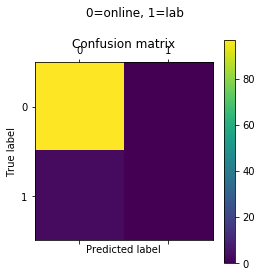

In [41]:
# Try Logistical regression with unbalanced classes.
#https://machinelearningmastery.com/what-is-imbalanced-classification/

# X, y are still the full dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y)

vectorizer = CountVectorizer() 
counts = vectorizer.fit_transform(X_train)

Spam_model = LogisticRegression(solver='liblinear', penalty='l1')
Spam_model.fit(counts, y_train)

example_count = vectorizer.transform(X_test)
pred = Spam_model.predict(example_count)
print( f'Accuracy score: {accuracy_score(y_test,pred)}' )
f1 = f1_score(y_test, pred, average='macro')
print( f'F1 score: {f1}' )
# Accuracy of 0.66% not the best but also not bad.
# TODO: Run this on bi/tri-grams data to see if that will be better.
# Instead of having a matrix of the differnt words, have matrix of different ngrams.

cm = confusion_matrix(y_test, pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# N-Gram data rather than target count data

The algorithms used above are just using the mouse target variables to varying success.
Try similar approaches to the balanced methods, but use bi/tri-gram data rather than just none/unigrams.



In [42]:
# TODO get a list of bi grams for each user.
# Turns out the Count Vectorizer has an ngram feature :/

# First do with unbalanced classes, then balanced.
X_train, X_test, y_train, y_test = train_test_split(X, y)

vectorizer_ngram = CountVectorizer(analyzer='word', ngram_range=(2, 2))
ngram_counts = vectorizer_ngram.fit_transform(X_train)
print(vectorizer_ngram.get_feature_names()) # Not sure if this worked correclty, lets try anyway lol.

X_test = vectorizer_ngram.transform(X_test) # TODO: SHould be treating alloc-slider-1/alloc-slider-2 as different n-grams.


['alloc slider', 'html alloc', 'html html', 'slider alloc', 'slider html']


Accuracy score: 0.94
F1 score: 0.4845360824742268
[[94  0]
 [ 6  0]]


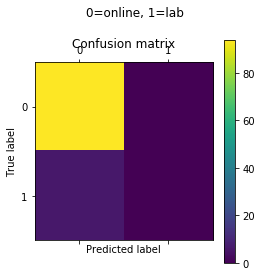

In [43]:

Spam_model = LogisticRegression(solver='liblinear', penalty='l1')
Spam_model.fit(ngram_counts, y_train)

pred = Spam_model.predict(X_test)
print( f'Accuracy score: {accuracy_score(y_test, pred)}' )
f1 = f1_score(y_test, pred, average='macro')
print( f'F1 score: {f1}' )
# Accuracy of 0.96 on unbalanced data

cm = confusion_matrix(y_test, pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

['alloc slider', 'html alloc', 'html html', 'slider alloc', 'slider html']

Accuracy score: 0.8571428571428571
F1 score: 0.8444444444444446
Train data matrix: 
 [[10  2]
 [ 3  6]]
Test data matrix: 
 [[2 0]
 [1 4]]


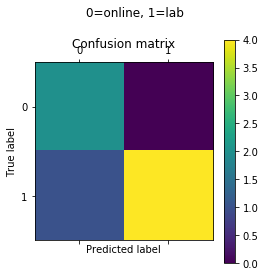

In [44]:
# Try with n-grams and balanced data.

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced)

vectorizer_ngram = CountVectorizer(analyzer='word', ngram_range=(2, 2))
ngram_counts = vectorizer_ngram.fit_transform(X_train)
print(vectorizer_ngram.get_feature_names()) # Not sure if this worked correclty, lets try anyway lol.

X_test = vectorizer_ngram.transform(X_test)

Spam_model = LogisticRegression(solver='liblinear', penalty='l1')
Spam_model.fit(ngram_counts, y_train)

pred = Spam_model.predict(X_test)
print( f'\nAccuracy score: {accuracy_score(y_test, pred)}' )
f1 = f1_score(y_test, pred, average='macro')
print( f'F1 score: {f1}' )
# Accuracy of 0.777 on balanced data
# Prety good, I imagine if this was working proberly itd be even better


cm = confusion_matrix(y_train, Spam_model.predict(ngram_counts))
print('Train data matrix: \n', cm)
cm = confusion_matrix(y_test, pred)
print('Test data matrix: \n', cm)

plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# Try HMM

Not entirely sure how these work but will word it out as I go along.


https://towardsdatascience.com/hidden-markov-models-for-time-series-classification-basic-overview-a59b74e5e65b
    Normally towardsdatascience is really good but this makes no sense to me at all.

Some guys github repository using HMM for binary sentimental analysis of tweets - https://github.com/FantacherJOY/Hidden-Markov-Model-for-NLP


"In the case one label is way more frequent than the other (say Class B appears for every 100 samples of Class A), or in the case one category is broader than the other (have more variance, i.e. Class A is an expected behavior of a process and Class B is all the cases that are abnormal), then we might want to train a unique HMM for Class A. For each new sample, we compute the likelihood to the model, and if it falls below a pre-defined threshold (that can be chosen with respect to some validation sample, or in the worst case, from the training samples themselves) we assign this sample to Class B. If the likelihood is above the threshold, we assign the sample to Class A." - https://datascience.stackexchange.com/questions/8560/can-hmm-be-used-as-a-binary-classifier

In [45]:
# TODO remove Duplicate data earlier to improve effeciency.
df_lab
print(f'Number of duplicate items in Lab data: {len(df_lab)-len(df_lab.drop_duplicates())}')
print(f'Number of duplicate items in Turk data: {len(df_turk)-len(df_turk.drop_duplicates())}')

Number of duplicate items in Lab data: 0
Number of duplicate items in Turk data: 0


In [46]:
# First get the targets data in a time series of time, target, and ID.

# When we remove the mouse event we have much more duplicate data.
# Drop this data and reset the indexes to account for missing values.
# Since there was a correlation between time and number of mouse events maybe I can use index to substitue for time.
df_markov = df_lab[['target', 'time', 'turkId']].drop_duplicates().reset_index(drop=True)
df_markov

,target,time,turkId
0,alloc-slider-5,0.000000,ID1
1,alloc-slider-5,0.547000,ID1
2,alloc-slider-5,1.176995,ID1
3,alloc-slider-5,1.790000,ID1
4,html,2.896995,ID1
...,...,...,...
27977,alloc-slider-2,273.796495,ID18
27978,alloc-slider-2,273.836415,ID18
27979,alloc-slider-2,273.924560,ID18
27980,html,274.968440,ID18


In [47]:
len(df_markov)-len(df_markov.drop_duplicates())

0

In [48]:
#TODO: https://medium.com/@a.ydobon/justforfunpython-n-gram-to-quantify-similarity-between-sentences-2d61e68a478c
# Use this method to compare one users targets with the rest of their class to get a similarity.
# Then can get the average similarity compared to the group of each target.
# Then compare similarity to other group e.g. how similar is this turk to a lab person.
# If any turk matches lab more then we boldly assume it belongs in the wrong class.

# This funciton works perfectly, its the other function that doesnt work properly lol.
def lists_similarity(list_a, list_b):
    # Calculates siilarity of list_a to list_b
    # Given 2 lists of ngrams, return how 'similar' lists are
    # Similarity is number of matching items / length of list a
    
    similar_count = 0
    common=[]

    for item_a in list_a:
        for item_b in list_b:
            if item_a == item_b:
                #print('MATCH')
                similar_count += 1
                common.append(item_a)


    #print('similar_count', similar_count)
    #print('len(list_a)', len(list_a))
    #print('len(list_b)', len(list_b))
    similarity = similar_count/len(list_a)
    return similarity#,common
    

In [49]:
# Look into similarity matrixes Tom seems to think theyre the same thing.

def compare_all(dataframe, n):
    IDs = dataframe['turkId'].unique()

    # First get a list of all the ngrams for each user in the dataframe
    users_ngrams_list = []

    for ID in IDs:
        targets = dataframe[ dataframe['turkId'] == ID ] ['target'].to_numpy()

        ngrams_generator = nltk.ngrams(targets, n)  # creates ngram generator, can be used to find ngrams
        ngrams_list = list(ngrams_generator)        # generator to list
        
        users_ngrams_list.append(ngrams_list)

    #users_ngrams_list # this is a list of lists. index 0 has a list of ngrams from the first user ID.


    # FIrst enumerates, a and b are essesnally a list of the unique users that we go through.
    # After that loop we index into the list, which contains a list of the ngrams of the user with that index
    # e.g. index 0 stores the ngrams about the first user at IDs[0]

    resutls = []    # results should end up being same length as num of IDs

    for index_a, ngrams_list_a in enumerate(users_ngrams_list):
        print(f'ID:{index_a} out of {len(users_ngrams_list)}')

        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)

        total_similarity = 0
        for index_b, ngrams_list_b in enumerate(users_ngrams_list):
            # compare list index_a's ngrams with list index_b's

            # we dont want to compare a list to itself for similarity
            if index_a != index_b:
                total_similarity += lists_similarity(ngrams_list_a, ngrams_list_b)

        #print('total_similarity', total_similarity)
        similarity_average = total_similarity/len(IDs)
        #print(f'{index_a} average similarity : {similarity_average}')
        resutls.append(similarity_average)

        #print('similarity_average', similarity_average)

    return pd.DataFrame( {'ID': IDs, 'Similarity': resutls} )

lab_sim = compare_all(df_lab, 2)
#turk_sim = compare_all(df_turk, 2) # start time 15:36

ID:0 out of 14
Current Time = 21:27:32
ID:1 out of 14
Current Time = 21:27:47
ID:2 out of 14
Current Time = 21:28:03
ID:3 out of 14
Current Time = 21:28:12
ID:4 out of 14
Current Time = 21:28:15
ID:5 out of 14
Current Time = 21:28:17
ID:6 out of 14
Current Time = 21:28:30
ID:7 out of 14
Current Time = 21:28:37
ID:8 out of 14
Current Time = 21:28:39
ID:9 out of 14
Current Time = 21:28:50
ID:10 out of 14
Current Time = 21:28:52
ID:11 out of 14
Current Time = 21:29:04
ID:12 out of 14
Current Time = 21:29:16
ID:13 out of 14
Current Time = 21:29:23


In [50]:
#turk_sim = compare_all(df_turk, 2) # start time 20:37

ID:0 out of 386
Current Time = 21:29:56


In [0]:
lab_sim

In [0]:
turk_sim.to_csv('turk_sim.csv') # Save as this took AGES to run
turk_sim.plot(kind='bar')